# 1. Settings
## 1) Import required libraries

In [5]:
!unzip animal

Archive:  animal.zip
  inflating: val/cats/105828578-1554223245858gettyimages-149052633.jpg  
  inflating: val/cats/220px-An_up-close_picture_of_a_curious_male_domestic_shorthair_tabby_cat.jpg  
  inflating: val/cats/960x0.jpg      
  inflating: val/cats/cat-image-2-600x375.jpg  
  inflating: val/cats/cat-with-blue-eyes-looks-at-camera-royalty-free-image-1587655932.jpg  
  inflating: val/cats/images.jpg     
  inflating: val/cats/otjbibjaAbiifyN9uVaZyL-650-80.jpg  
  inflating: val/cats/Scottish-fold-cat-feline.jpg  
  inflating: val/cats/_111434467_gettyimages-1143489763.jpg  
  inflating: val/dogs/322868_1100-1100x628.jpg  
  inflating: val/dogs/3408.jpg       
  inflating: val/dogs/Chinook-On-White-03.jpg  
  inflating: val/dogs/dog-puppy-on-garden-royalty-free-image-1586966191.jpg  
  inflating: val/dogs/maxresdefault.jpg  
  inflating: val/dogs/unnamed.jpg    
val/dogs/다운로드 (1).jpg:  mismatching "local" filename (val/dogs/ыЛдьЪ┤ыбЬыУЬ (1).jpg),
         continuing with "central" f

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils

## 2) Hyperparameter

In [2]:
batch_size = 8
learning_rate = 0.0001
epoch = 20

n_node = 1024 # customized last layer의 노드 수. 64, 128,256,512,1024
dropratio = 0.5 # 얼마나 드랍시킬지 inverse keepratio

imgsize = 256

# 2. Data Loader
## 트레이닝 데이터

In [3]:
img_dir = "animal/train"
train_data = dset.ImageFolder(img_dir, transforms.Compose([
    transforms.CenterCrop(imgsize*2),
    transforms.RandomCrop(imgsize),
    transforms.RandomHorizontalFlip(),
    
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))
print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

46


## 고정된 데이터셋

In [4]:
# 2. Dev Data
img_dir = "animal/val"
dev_data = dset.ImageFolder(img_dir, transforms.Compose([
    #transforms.Scale(256),
    #transforms.RandomSizeCrop(224),
    
    transforms.CenterCrop(size = imgsize),  
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))

dev_batch = data.DataLoader(dev_data, batch_size=batch_size, shuffle=True, num_workers=2)

In [5]:
# 3. Test Data
img_dir = 'animal/test'
test_data = dset.ImageFolder(img_dir, transforms.Compose([
    #transforms.Scale(256),
    #transforms.RandomSizeCrop(224),
    
    transforms.CenterCrop(size = imgsize),  
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))

test_batch = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)

In [6]:
nclass = len(train_data.classes)
print("# of classes: %d"%nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d"%(train_data.__len__(), dev_data.__len__(), test_data.__len__()))

# of classes: 2
['cats', 'dogs']
{'cats': 0, 'dogs': 1}
46
Training: 46, Dev: 17, Test: 41


In [7]:
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['cats', 'dogs']
['cats', 'dogs']
['cats', 'dogs']


# 3. Model
## 1) Pretrained VGG Model

In [8]:
vgg = models.vgg19(pretrained=True)

for name, module in vgg.named_children():
    print(name)
    
print(list(vgg.children())[0])
print(list(vgg.children())[-1])


features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

In [9]:
print(list(vgg.children())[0][0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


## 2) Customized Fully Model

In [10]:
base_dim = 64
fsize = int(imgsize/32)

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG, self).__init__()
        self.layer0 = nn.Sequential(*list(vgg.children())[0])
        
        self.layer1 = nn.Sequential(
            nn.Linear(8*base_dim * fsize * fsize, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, nclass),
        )
        # weight initialization
        for m in self.layer1.modules():
            #print(m)
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
    def forward(self, x):
        # layer0의 사이즈를 무식하게 프린트해서 알아낼 수 있음..(batchsize, x,x,x)
        #print(x.size())
        out = self.layer0(x)
        out = out.view(out.size(0), -1)
        out = self.layer1(out)
        return out

## 3) Model on GPU

In [11]:
model = MyVGG().cuda()

for params in model.layer0.parameters():
    params.required_grad = False

for params in model.layer1.parameters():
    params.required_grad = False

C:\Users\DY\.conda\envs\wiset\lib\site-packages\ipykernel_launcher.py:29: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [12]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# 4. Optimizer & Loss

In [13]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(), lr=learning_rate)

# 5. Train

In [14]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [16]:
import utils

print('start')
total_time = 0
disp_step = 10

to_train = True
if(to_train==False):
    print('false')
    netname='./nets/catdog_vgg19_10.pkl'
    model = torch.load(netname)
else:
    print("3 layer, n_node: %d, dropratio: %.2f"%(n_node, dropratio))
    model.eval()
    train_corr = utils.ComputeCorr(train_batch, model)
    dev_corr = utils.ComputeCorr(dev_batch, model)
    test_corr = utils.ComputeCorr(test_batch, model)
    print("Correct of train: %.2f, dev: %.2f, test: %.2f"%(train_corr, dev_corr, test_corr))
    model.train()
    
    netname = './nets/catdob_vgg19'
    
    # graph 그리기
    x_epoch = []
    y_train_err = []
    y_dev_err = []
    y_test_err = []
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
#     # 학습 재시작 한다면...
#     netname= '../nets/media_pre_vgg19.pkl'
#     model = torch.load(netname)
#     # 파라미터 학습여부 결정
#     for params in model.layer0.parameters():
#         params.required_grad=False
#     for params in model.layer1.parameters():
#         params.required_grad=False
#     for i in range(34, epoch):

    # 재시작하지 않는다면
    for i in range(epoch):
        start_time = time.time()
        print("%d.."%i),
        for img, label in train_batch:
            img = Variable(img).cuda()
            label = Variable(label).cuda()
            
            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()
        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        if (i%disp_step==0) or (i==epoch-1):
            torch.save(model, netname+'_%d.pkl'%i, )
            print("\n[%d/%d] loss: %.3f, "%(i, epoch, (loss.cpu()).data.numpy()))
            
            # evaluation(test) mode로 바꾸기 -> dropout, batch normalization에 영향 줌
            model.eval()
            
            # train, dev, train accr
            train_corr = utils.ComputeCorr(train_batch, model)
            dev_corr = utils.ComputeCorr(dev_batch, model)
            test_corr = utils.ComputeCorr(test_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f, "%(train_corr, dev_corr, test_corr)),
            model.train()
            print("time: %.2f sec... "%(total_time))
            
            # graph 그리기
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
    print("Total time: %.2f sec"%total_time)

start
3 layer, n_node: 1024, dropratio: 0.50
Correct of train: 67.39, dev: 70.59, test: 82.93
0..

[0/20] loss: 0.496, 
Correct of train: 80.43, dev: 70.59, test: 85.37, 
time: 2.98 sec... 
1..
2..
3..
4..
5..
6..
7..
8..
9..
10..

[10/20] loss: 0.411, 
Correct of train: 95.65, dev: 76.47, test: 100.00, 
time: 32.84 sec... 
11..
12..
13..
14..
15..
16..
17..
18..
19..

[19/20] loss: 0.182, 
Correct of train: 100.00, dev: 70.59, test: 100.00, 
time: 60.09 sec... 
Total time: 60.09 sec


내 로컬에서 RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 4.00 GiB total capacity; 2.43 GiB already allocated; 0 bytes free; 2.49 GiB reserved in total by PyTorch) 에러
- batch_size를 16 -> 8로 줄여 해결.

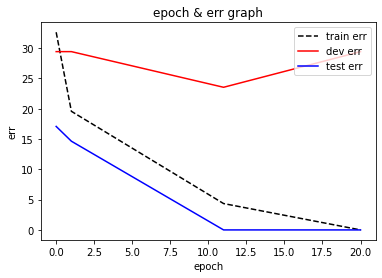

In [19]:
# epoch-err curve
if(to_train):
    plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
    plt.plot(x_epoch, y_dev_err, color='red', label='dev err')    
    plt.plot(x_epoch, y_test_err, color='blue', label='test err')
    
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc ="upper right")
    plt.show()

# 6. Evaluation for dev & test data

Normalized confusion matrix


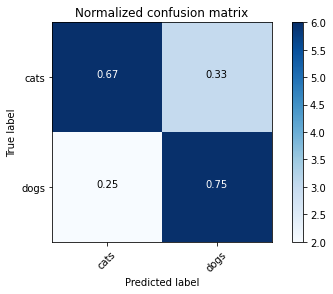

Confusion matrix, without normalization


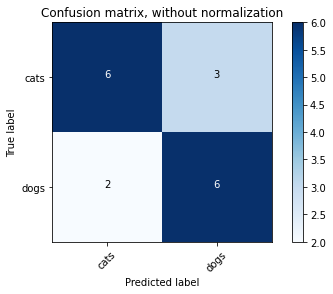

	 acc  |	 pre  |	 rec  |	 f1
 cats: 0.71 |	 0.75 |	 0.67 |	 0.71
 dogs: 0.71 |	 0.67 |	 0.75 |	 0.71
*accuracy: 0.71, precision: 0.71, recall: 0.71, *f1 score: 0.71
[AP]
cats: 0.93
dogs: 0.93

[mAP] 0.931
[miAP] 0.853


(array([0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0]),
 array([0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0]),
 array([0.89153755, 0.89781934, 0.99909049, 0.77979451, 0.57008904,
        0.99981308, 0.99979675, 0.99954069, 0.81005436, 0.99150765,
        0.72767472, 0.50026923, 0.95540911, 0.99846089, 0.99743211,
        0.60928971, 0.71209824]))

In [20]:
model.eval() # evaluation(test)모드로 바꾸기
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Normalized confusion matrix


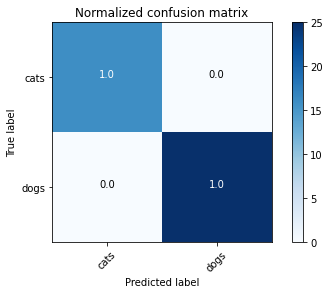

Confusion matrix, without normalization


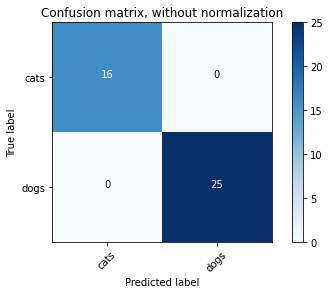

	 acc  |	 pre  |	 rec  |	 f1
 cats: 1.00 |	 1.00 |	 1.00 |	 1.00
 dogs: 1.00 |	 1.00 |	 1.00 |	 1.00
*accuracy: 1.00, precision: 1.00, recall: 1.00, *f1 score: 1.00
[AP]
cats: 1.00
dogs: 1.00

[mAP] 1.000
[miAP] 1.000


In [21]:
model.eval()

_, _, _ = utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

Category: cats
 True predicted images/total cats category: 6 / 9
Predicted probability:
[9.9954069e-01 4.5933505e-04]


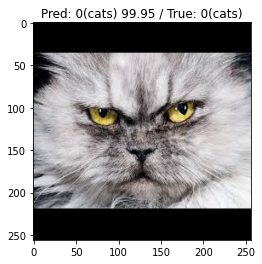

Predicted probability:
[0.99150765 0.00849236]


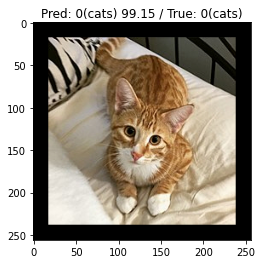

 False predicted images/total cats category: 3 / 9
Predicted probability:
[0.49973077 0.50026923]


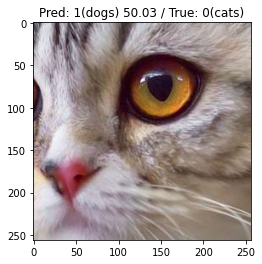

Predicted probability:
[0.2723253 0.7276747]


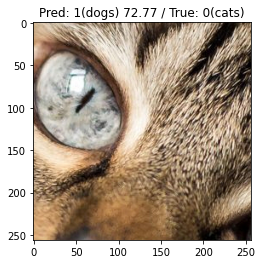

Category: dogs
 True predicted images/total dogs category: 6 / 8
Predicted probability:
[9.095121e-04 9.990905e-01]


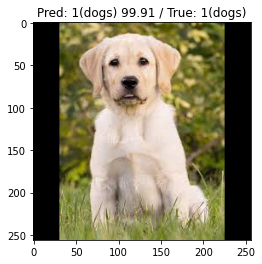

Predicted probability:
[0.10218068 0.89781934]


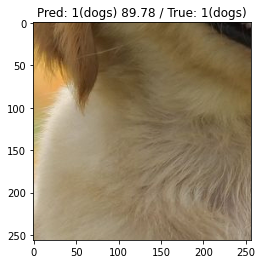

 False predicted images/total dogs category: 2 / 8
Predicted probability:
[0.57008904 0.42991096]


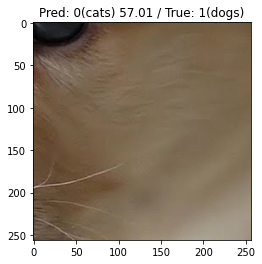

Predicted probability:
[0.6092897 0.3907103]


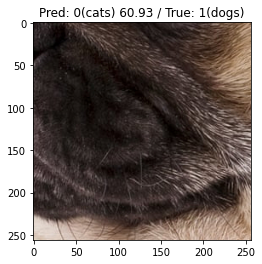

In [24]:
utils.VisTFPred(dev_batch, model, test_data.classes, batch_size, i_n=2)